In [2]:
import pandas as pd
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
from utils import setup_plotting_standards, plotTree, plotPoints
import baltic as bt

setup_plotting_standards()
COLOR = '#343434'

# Supplemental Figure 1: Distribution of IncA/C plasmids
Here we assess the distribution of IncA/C plasmids in isolates of the third wave of 7PET.

First, we load in the metadata for all samples used in the phylogeny. We previously found the presence of IncA/C in pubicly available sequences by assessing literature, and scanned denovo assemblies of our own sequences for plasmids using PlasmidFinder. These values have been placed in the `IncA/C` column of the metadata. 

In [3]:
md = list()
for file in ["supplemental_data1.csv", "supplemental_data2.csv"]:
    df = pd.read_csv( "../data/" + file, usecols=["taxa", "IncA/C", "te"] )
    df["workshop"] = (file == "supplemental_data1.csv")
    md.append( df )
    
md = pd.concat( md )
md = md.drop_duplicates()
md = md.set_index( "taxa" )
md.head()

,te,IncA/C,workshop
taxa,,,
Africa|CMR|CMR_CEN005NA35|T12|2023-04-12,T12,False,True
Africa|CMR|CMR_CEN032BM-B48|T12|2023-05-04,T12,False,True
Africa|CMR|CMR_E05557442|T12|2023-05-12,T12,False,True
Africa|CMR|CMR_CEN030DA43|T12|2023-05-03,T12,False,True
Africa|CMR|CMR_CEN027NV44|T12|2023-05-01,T12,False,True


Next, we load the MCC tree from our bayesian phylogenetic reconstruction.

In [4]:
tree = bt.loadNexus( "../beast-analyses/2024-08-06_constant_relaxed.mcc.tree" )
tree.treeStats()


Tree height: 55.498287
Tree length: 4025.387818
strictly bifurcating tree
annotations present

Numbers of objects in tree: 5071 (2535 nodes and 2536 leaves)


Finally, we plot the tree labeling taxa by whether we have evidence of IncA/C or not. This generates Supplemental Figure 1.

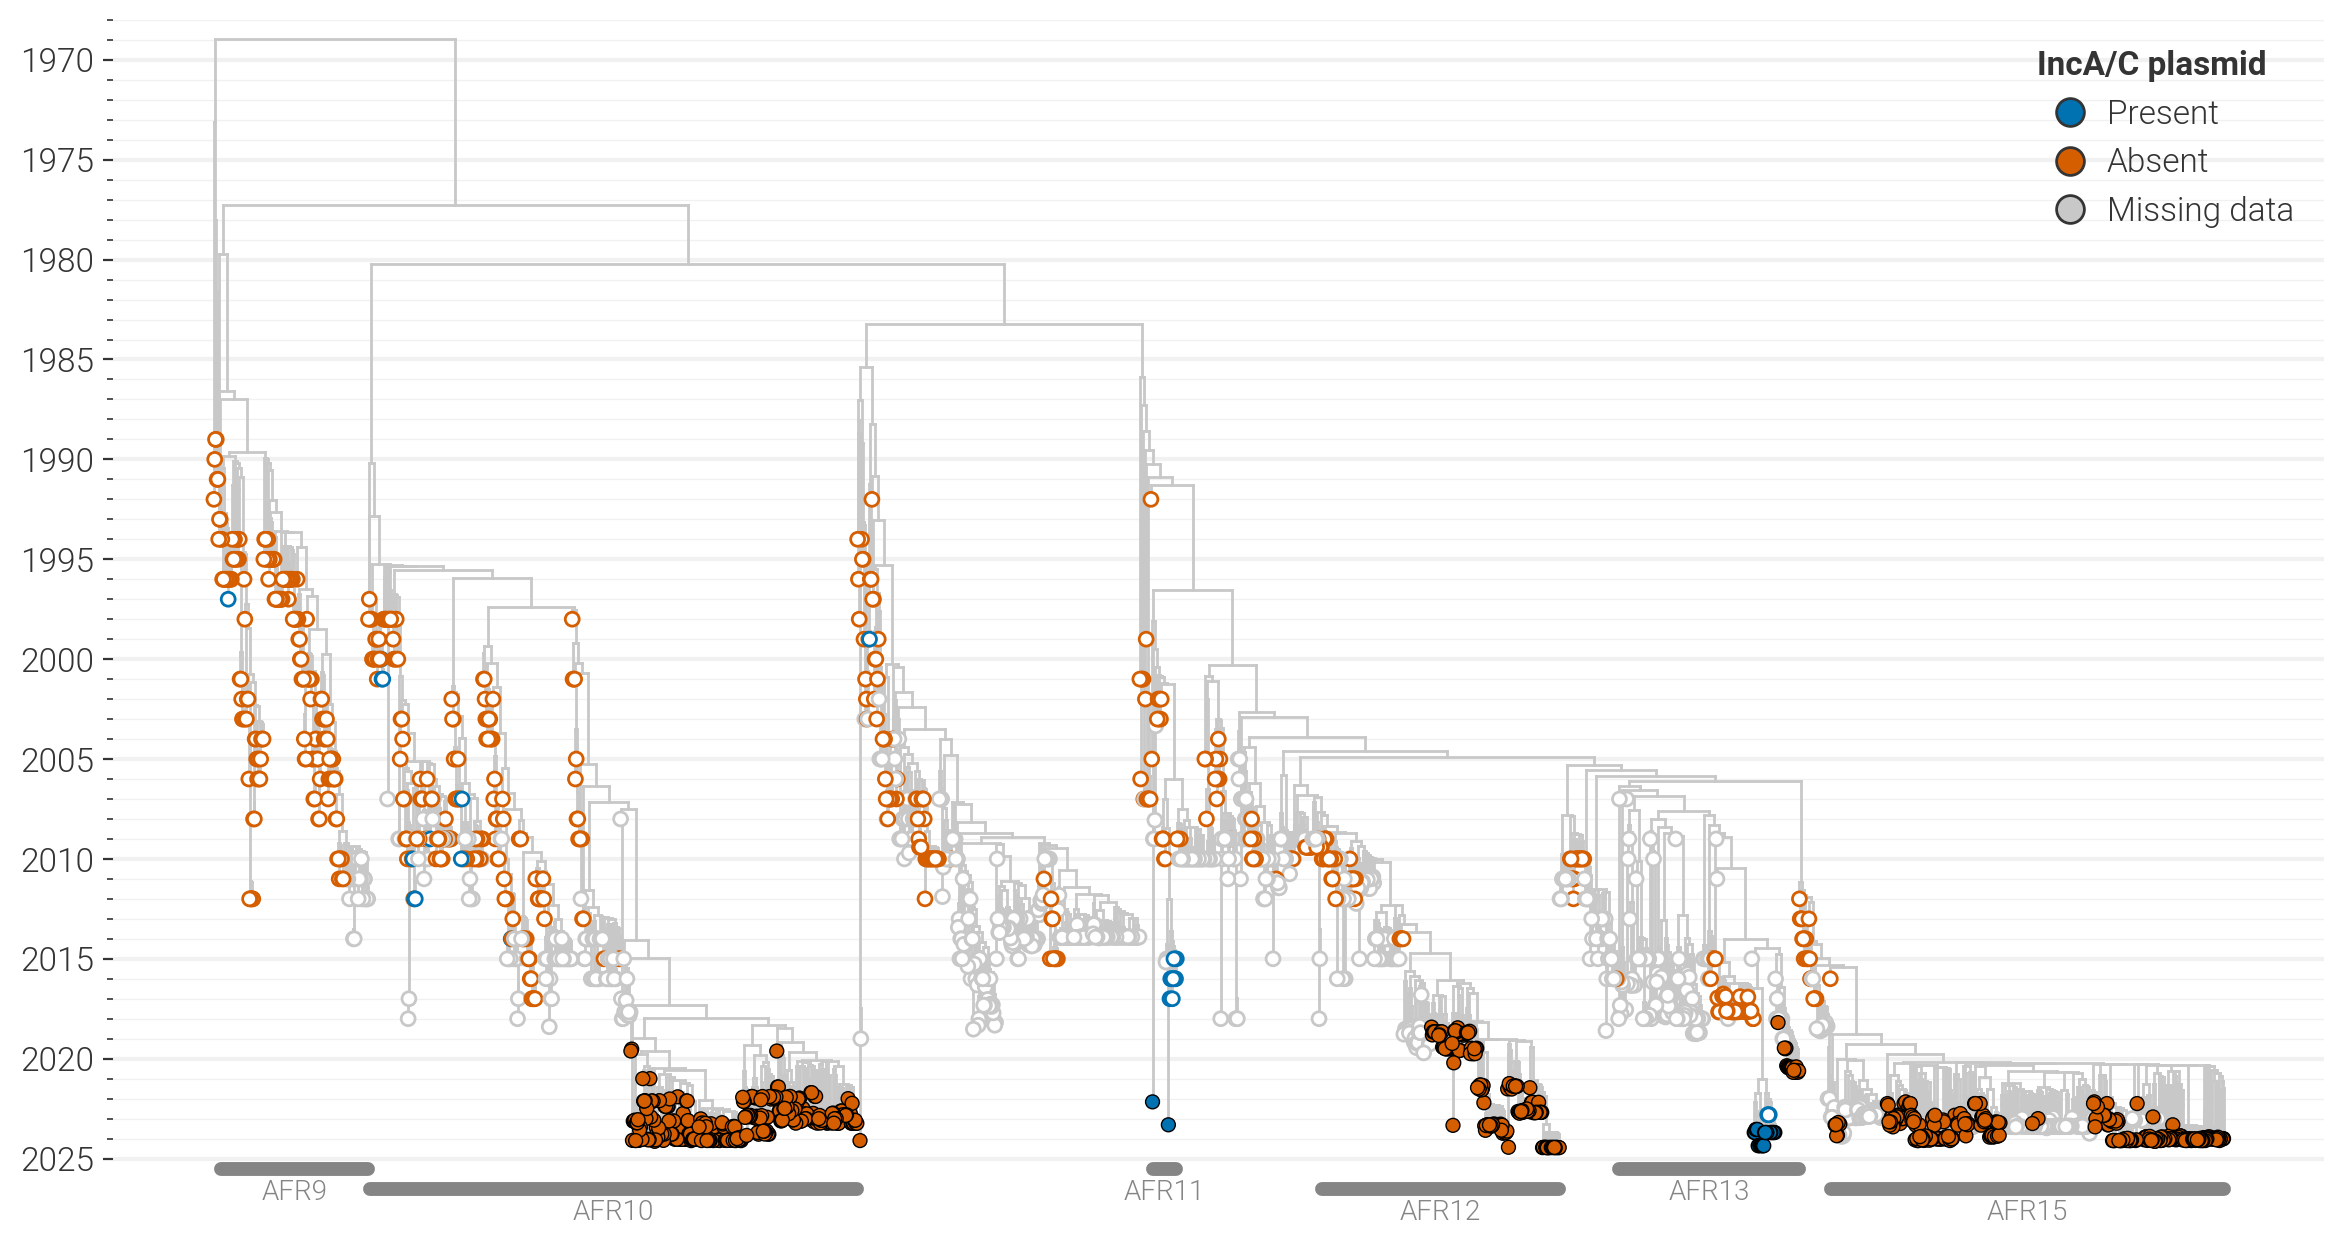

In [6]:
color_map = {
    "Not tested" : "#C8C8C8",
    "Present" : "#0072B2",
    "Absent" : "#ffac6a"
}

def color_func( label ):
    res = md.loc[label]["IncA/C"]
    if pd.isna( res ):
        return color_map["Not tested"]
    elif res:
        return color_map["Present"]
    else:
        return color_map["Absent"]

def is_workshop( node, inverse=False ):
    if node.is_leaf():
        if inverse:
            return not md.loc[node.name, "workshop"]
        return md.loc[node.name, "workshop"]
    return False

fig, ax = plt.subplots( dpi=200, figsize=(12, 6.5) )
x_attr = lambda k: k.absoluteTime
node_func = lambda k: color_func( k.name )
c_func = lambda k: "#C8C8C8"
plotTree( tree, ax, x_attr=x_attr, colour=color_map["Not tested"], linewidth=1, horizontal=True )
plotPoints( tree, ax, x_attr=x_attr, target=lambda x: is_workshop(x, inverse=True), size=25, colour="w", outline_colour=node_func, outline_size=40, zorder=100, horizontal=True, style="nate", linewidth=1 )
plotPoints( tree, ax, x_attr=x_attr, target=is_workshop, size=25, colour=node_func, zorder=150, horizontal=True, style="nate", linewidth=0.5 )
#small_tree.plotPoints( ax, x_attr=x_attr, target=lambda k : k.is_node() & (int( k.traits.get( "label", 0) ) > 50), color=COLOR, size=5 )

ax.set_xticks([])
ax.set_xticklabels([])
ax.tick_params( axis="y", left=False, right=False, which="both", labelbottom=True, rotation=0, labelsize=12 )

ax.set_yticks( range( 1965, 2030, 5 ), minor=False )
ax.set_yticks( range( 1965, 2026 ), minor=True )
ax.set_ylim( 1968, 2027 )

ax.grid( which="major", axis="y", linewidth=1.5, color="#F1F1F1", zorder=1 )
ax.grid( which="minor", axis="y", linewidth=0.5, color="#F1F1F1", zorder=1 )

[ax.spines[loc].set_visible(False) for loc in ax.spines]
ax.invert_yaxis()
ax.invert_xaxis()


legend2 = [
    Line2D([0], [0], linestyle='none', marker='o', color=color_map["Present"], markeredgecolor=COLOR, markeredgewidth=1, label="Present", markersize=10 ),
    Line2D([0], [0], linestyle='none', marker='o', color=color_map["Absent"], markeredgecolor=COLOR, markeredgewidth=1, label="Absent", markersize=10 ),
    Line2D([0], [0], linestyle='none', marker='o', color=color_map["Not tested"], markeredgecolor=COLOR, markeredgewidth=1, label="Missing data", markersize=10 )
]

legend2 = ax.legend( title="IncA/C plasmid", handles=legend2, loc="upper right", handletextpad=0.1, frameon=False, fontsize=12, alignment="left", title_fontproperties={ "size" : 12, "weight" : "bold" })

count = 0
for lin in ["T9", "T10", "T11", "T12", "T13", "T15"]:
    representatives = md.loc[md["te"]==lin].index.to_list()
    span = [tip.y for tip in tree.getExternal() if tip.name in representatives]
    min_span = min( span )
    max_span = max( span )
##    span = sorted( [tip.y for tip in tree.getExternal( lambda x: x.name in lineage_dict[lin] )] )
    yloc = 2025.5 + 1 * (count % 2)
    ax.hlines( yloc, min_span, max_span, colors=COLOR, alpha=0.6, linewidth=5, capstyle="round", label=lin )
    ax.text( (min_span + max_span) / 2, yloc+1.2, lin.replace( "T", "AFR" ), ha="center", va="center", fontsize=10, alpha=0.6 )
    
    count += 1

plt.tight_layout()
fig.savefig( "plots/figureS5-phylogenetic-tree-AMR.pdf", bbox_inches='tight' )
fig.savefig( "plots/figureS5-phylogenetic-tree-AMR.png", bbox_inches='tight' )
plt.show()